In [1]:
import pandas as pd
import numpy as np
from dsipts import TimeSeries, RNN,read_public_dataset, LinearTS, Persistent, TFT
import matplotlib.pyplot as plt
from datetime import timedelta
import logging
import sys
import random


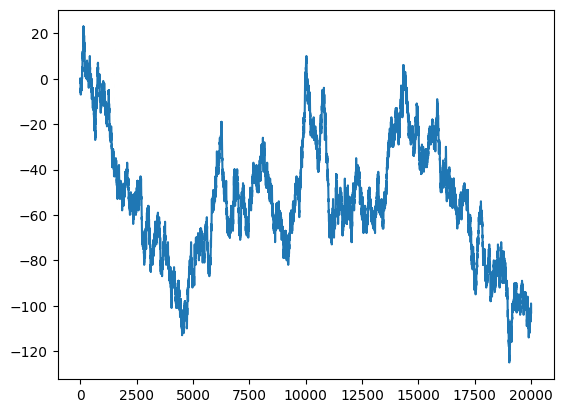

In [46]:
def random_walk(n,level=3000):
    tot = np.zeros(n)
    probs = np.zeros(n)
    for i in range(n-1):
        prob = random.random()
        if prob<0.5:
            delta = 1
        else:
            delta = -1
        tot[i+1] = tot[i] + delta
        
        probs[i+1]= prob +(random.random()/level-0.5/level)
    return tot, probs
N = 20000
random.seed(330)
x, p = random_walk(N)
data = pd.DataFrame({'y':x/x.max(),'p':p,'time':range(N)})
plt.plot(x)

In [47]:
from catboost import CatBoostRegressor
regressor = CatBoostRegressor(loss_function='MultiRMSE')


In [48]:
##load the timeseries to the datastructure, adding the hour column and use all the covariates
ts = TimeSeries('weather')
ts.load_signal(data,enrich_cat=[],target_variables=['y'],past_variables= [],future_variables=['p'])
ts

Timeseries named weather of length 20000.
 Categorical variable: [],
 Future variables: ['p'],
 Past variables: ['y'],
 Target variables: ['y']
 With no group

In [49]:
#Let now prepare a model predictin the next 16 step using the past 16 steps 
past_steps = 64
future_steps = 64


In [50]:
##splitting parameters
split_params = {'perc_train':0.6,'perc_valid':0.2,                             ##if not None it will split 70% 10% 20%
               'range_train':None, 'range_validation':None, 'range_test':None, ## or we can split using ranges for example range_train=['2021-02-03','2022-04-08']
               'past_steps':past_steps,
               'future_steps':future_steps,
               'shift':0,
               'starting_point':None,                                          ## do not skip samples
               'skip_step' : 1                                                 ## distance between two consecutive samples
                             }

In [51]:
train,validation,test = ts.split_for_train(**split_params)

In [52]:
def transform(dataset):
    x_num = dataset.data['x_num_past']
    x_fut =  dataset.data['x_num_future']
    y =  dataset.data['y'].squeeze()
    x = np.hstack([x_num.squeeze(),x_fut.squeeze()])
    return {'X':x,'y':y}

In [53]:
regressor.fit(**transform(train))

0:	learn: 7.7077004	total: 908ms	remaining: 15m 7s
1:	learn: 7.5006951	total: 1.85s	remaining: 15m 23s
2:	learn: 7.3070603	total: 2.81s	remaining: 15m 34s
3:	learn: 7.1140611	total: 3.77s	remaining: 15m 40s
4:	learn: 6.9290287	total: 4.99s	remaining: 16m 32s
5:	learn: 6.7478022	total: 6.13s	remaining: 16m 56s
6:	learn: 6.5733618	total: 7.28s	remaining: 17m 13s
7:	learn: 6.4086046	total: 8.8s	remaining: 18m 10s
8:	learn: 6.2446813	total: 9.89s	remaining: 18m 9s
9:	learn: 6.0856785	total: 11s	remaining: 18m 4s
10:	learn: 5.9293123	total: 11.9s	remaining: 17m 49s
11:	learn: 5.7762873	total: 13.1s	remaining: 17m 54s
12:	learn: 5.6338738	total: 14.2s	remaining: 17m 59s
13:	learn: 5.4937085	total: 15.3s	remaining: 17m 54s
14:	learn: 5.3570516	total: 16.4s	remaining: 17m 55s
15:	learn: 5.2269725	total: 17.5s	remaining: 17m 58s
16:	learn: 5.0980476	total: 18.6s	remaining: 17m 56s
17:	learn: 4.9751237	total: 19.6s	remaining: 17m 48s
18:	learn: 4.8573110	total: 20.6s	remaining: 17m 43s
19:	learn

In [54]:
transform(test)
res =regressor.predict(transform(test)['X'])

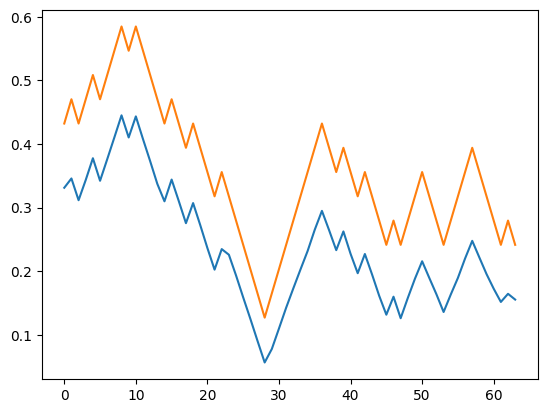

In [56]:
plt.plot(res[18])
plt.plot(transform(test)['y'][18])

In [146]:
%matplotlib qt
lag = 15

plt.plot(res[res.lag==lag].time, res[res.lag==lag].y,label='real',alpha=0.5)
plt.plot(res[res.lag==lag].time, res[res.lag==lag].y_pred,label='pred',alpha=0.5)

plt.title('Prediction on test for lag=7')
plt.legend()

In [147]:
res['prediction_time'] = res.apply(lambda x: int(x.time-x.lag), axis=1)

In [148]:
res

,lag,time,y,y_pred,prediction_time
0,1,16064,0.377953,0.399360,16063
1,1,16065,0.370079,0.389656,16064
2,1,16066,0.377953,0.395594,16065
3,1,16067,0.385827,0.403635,16066
4,1,16068,0.377953,0.401778,16067
...,...,...,...,...,...
247803,64,19994,0.771654,0.673848,19930
247804,64,19995,0.763780,0.676096,19931
247805,64,19996,0.755906,0.673301,19932
247806,64,19997,0.748031,0.675759,19933


In [150]:
%matplotlib qt
date = 19932

plt.plot(res[res.prediction_time==date].time, res[res.prediction_time==date].y,label='real',alpha=0.5)
plt.plot(res[res.prediction_time==date].time, res[res.prediction_time==date].y_pred,label='pred',alpha=0.5)
#plt.ylim(res.y.min(),res.y.max())
plt.title('Prediction on test for lag=7')
plt.legend()

In [ ]:
## get the median MSE for each lag
import numpy as np
res.groupby('lag').apply(lambda x: np.nanmean((x.y-x.y_median)**2)).reset_index().rename(columns={0:'error'}) 

In [ ]:
#save model 
ts.save(f"{model_to_use}_test")

In [ ]:
## load the model and check if we obtain the same result

In [ ]:
ts.load(LinearTS,f"{model_to_use}_test",load_last=False)
res = ts.inference_on_set(200,4,set='test',rescaling=True)
error = res.groupby('lag').apply(lambda x: np.nanmean((x.y-x.y_median)**2)).reset_index().rename(columns={0:'error'}) 
error

In [ ]:
##print the mean MSE along the lag steps
plt.plot(error.lag,error.error)

In [ ]:
%matplotlib inline
lag = 7
try:
    %matplotlib qast
    to_plot = res
except:
    print('better to have qt, i will reduce the dataset')
    plt.figure(figsize=(15,7))
    to_plot = res[res.time>pd.to_datetime('2020-12-28')]
plt.plot(to_plot[to_plot.lag==lag].time, to_plot[to_plot.lag==lag].y,label='real',alpha=0.5)
plt.plot(to_plot[to_plot.lag==lag].time, to_plot[to_plot.lag==lag].y_median,label='median',alpha=0.5)
plt.fill_between(to_plot[to_plot.lag==lag].time, to_plot[to_plot.lag==lag].y_low , to_plot[to_plot.lag==lag].y_high, alpha=0.2,label='error band')

plt.title('Prediction on test for lag=7')
plt.legend()

In [ ]:
tot = pd.read_csv('/home/agobbi/Projects/ExpTS/csv/prova_test_tot_predictions.csv')
tot.time = pd.to_datetime(tot.time)

In [ ]:
pers = tot[(tot.model=='persistent_weather_1')]

In [ ]:
%matplotlib inline
lag = 7
try:
    %matplotlib qast
    to_plot = pers
except:
    print('better to have qt, i will reduce the dataset')
    plt.figure(figsize=(15,7))
    to_plot = pers[pers.time>pd.to_datetime('2020-12-28')]
plt.plot(to_plot[to_plot.lag==lag].time, to_plot[to_plot.lag==lag].y,label='real',alpha=0.5)
plt.plot(to_plot[to_plot.lag==lag].time, to_plot[to_plot.lag==lag].y_pred,label='median',alpha=0.5)
plt.fill_between(to_plot[to_plot.lag==lag].time, to_plot[to_plot.lag==lag].y_low , to_plot[to_plot.lag==lag].y_high, alpha=0.2,label='error band')

plt.title('Prediction on test for lag=7')
plt.legend()